In [5]:
subject_id: int = 3
low_cut_hz: float = 4.
high_cut_hz: float = 38.
n_epochs: int = 3

In [6]:
import pooch
import pooch.utils

In [7]:
def download_patch(*args,fname=None,path=None, **kwargs):
    path = pooch.utils.cache_location(path, env=None, version=None)
    full_path = path.resolve() / fname
    print('Not downloading to avoid side effects')
    return str(full_path)

pooch.retrieve = download_patch

In [8]:
from braindecode.datasets.moabb import MOABBDataset

dataset = MOABBDataset(dataset_name="Schirrmeister2017", subject_ids=[subject_id])

Extracting EDF parameters from /home/jovyan/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/train/3.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as type EEG (renamed to 'Fz').
Channel 'EEG F4' recognized as type EEG (renamed to 'F4').
Channel 'EEG F8' recognized as type EEG (renamed to 'F8').
Channel 'EEG FC5' recognized as type EEG (renamed to 'FC5').
Channel 'EEG FC1' recognized as type EEG (renamed to 'FC1').
Channel 'EEG FC2' recognized as type EEG (renamed to 'FC2').
Channel 'EEG FC6' recognized as type EEG (renamed to 'FC6').
Channel 'EEG M1' recognized as type EEG (renamed to 'M1').
Channel 'EEG T7' recognized as type EEG (renamed to 'T7').
C

In [3]:
from braindecode.datautil.preprocess import (
    exponential_moving_standardize, preprocess, Preprocessor)

low_cut_hz = low_cut_hz
high_cut_hz = high_cut_hz

factor_new = 1e-3
init_block_size = 1000

preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
    Preprocessor(lambda x: x * 1e6),  # Convert from V to uV
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
    Preprocessor(exponential_moving_standardize,  # Exponential moving standardization
                 factor_new=factor_new, init_block_size=init_block_size)
]

preprocess(dataset, preprocessors)

Reading 0 ... 3347499  =      0.000 ...  6694.998 secs...


/opt/conda/envs/demo-env/lib/python3.9/site-packages/braindecode/datautil/preprocess.py:10: UserWarning: datautil.preprocess module is deprecated and is now under preprocessing.preprocess, please use from import braindecode.preprocessing.preprocess
  warn('datautil.preprocess module is deprecated and is now under '
/opt/conda/envs/demo-env/lib/python3.9/site-packages/braindecode/preprocessing/preprocess.py:52: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 825 samples (1.650 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    8.8s finished


Reading 0 ... 609499  =      0.000 ...  1218.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 825 samples (1.650 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    1.5s finished


In [4]:
from braindecode.datautil.windowers import create_windows_from_events

trial_start_offset_seconds = -0.5
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)

splitted = windows_dataset.split('run')
train_set = splitted['train']
valid_set = splitted['test']

Used Annotations descriptions: ['feet', 'left_hand', 'rest', 'right_hand']
Adding metadata with 4 columns
880 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 880 events and 2250 original time points ...


/opt/conda/envs/demo-env/lib/python3.9/site-packages/braindecode/datautil/windowers.py:4: UserWarning: datautil.windowers module is deprecated and is now under preprocessing.windowers, please use from import braindecode.preprocessing.windowers
  warn('datautil.windowers module is deprecated and is now under '


0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'rest', 'right_hand']
Adding metadata with 4 columns
160 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 160 events and 2250 original time points ...
0 bad epochs dropped


In [5]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
# Extract number of chans and time steps from dataset
n_chans = train_set[0][0].shape[0]
input_window_samples = train_set[0][0].shape[1]

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# Send model to GPU
if cuda:
    print("Using GPU")
    model.cuda()
else:
    print("Using CPU")


/opt/conda/envs/demo-env/lib/python3.9/site-packages/braindecode/util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


Using GPU


In [6]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier
# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)

clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr      dur
-------  ----------------  ------------  ----------------  ------------  ------  -------
      1            0.5864        1.6701            0.5312        1.0932  0.0006  12.6085
      2            0.6977        1.1627            0.5500        1.0140  0.0003  5.1923
      3            0.6943        0.9755            0.5563        1.0144  0.0000  4.9970


<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=ShallowFBCSPNet(
    (ensuredims): Ensure4d()
    (dimshuffle): Expression(expression=transpose_time_to_spat) 
    (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
    (conv_spat): Conv2d(40, 40, kernel_size=(1, 128), stride=(1, 1), bias=False)
    (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_nonlin_exp): Expression(expression=square) 
    (pool): AvgPool2d(kernel_size=(75, 1), stride=(15, 1), padding=0)
    (pool_nonlin_exp): Expression(expression=safe_log) 
    (drop): Dropout(p=0.5, inplace=False)
    (conv_classifier): Conv2d(40, 4, kernel_size=(144, 1), stride=(1, 1))
    (softmax): LogSoftmax(dim=1)
    (squeeze): Expression(expression=squeeze_final_output) 
  ),
)

In [9]:
import pandas as pd

# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])
df

,train_loss,valid_loss,train_accuracy,valid_accuracy
1,1.670140,1.093214,0.586364,0.53125
2,1.162744,1.014016,0.697727,0.55000
3,0.975512,1.014430,0.694318,0.55625


<AxesSubplot:>

<Figure size 640x480 with 0 Axes>

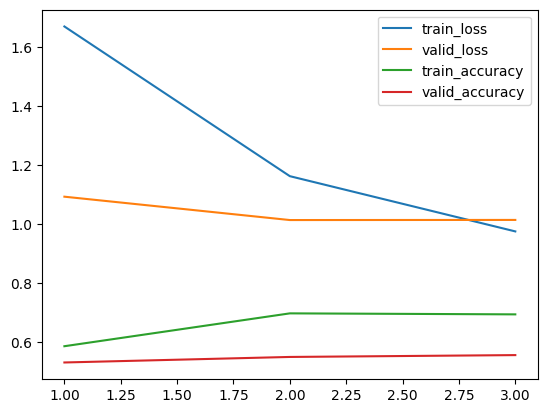

In [15]:
import matplotlib.pyplot as mp
mp.figure()
df.plot()

In [23]:
import os
job_name = os.environ.get('JOB_NAME', None)

if job_name is not None:  
    model_file = f"{job_name}.model.pt"
    model_path = os.path.join(os.getcwd(), model_file)
else:
    model_path = os.path.join(os.getcwd(), 'model.pt')

if not os.path.exists(model_path):
    torch.save(model.state_dict(), model_path)
    print(f"saved model to {model_path}")
else:
    print(f"failed to save model to path {model_path}: file exists")

failed to save model to path /home/jovyan/model.pt: file exists
